In [43]:
from datetime import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from gurobipy import *

## API Call + Data Preprocessing

In [44]:
# Create a list of symbols
symbols = ["NVDA", "GOOG", "AMZN", "AAPL", "META", "TSLA"]

daily_prices = yf.download(
  tickers = ' '.join(symbols), 
  start = datetime(2023, 12, 29),
  end = datetime(2025, 1, 1)
)['Adj Close']

daily_prices.columns = symbols

# Compute daily simple returns
daily_returns = (
  daily_prices.pct_change()
            .dropna(
              # Drop the first row since we have NaN's
              axis = 0,
              how = 'any',
              inplace = False
              )
)

# daily_returns = daily_returns.reset_index()
daily_returns

[*********************100%%**********************]  6 of 6 completed


,NVDA,GOOG,AMZN,AAPL,META,TSLA
Date,,,,,,
2024-01-02,-0.035787,-0.013229,-0.009721,-0.021669,-0.027341,-0.000241
2024-01-03,-0.007488,-0.009738,0.005732,-0.005256,-0.012436,-0.040134
2024-01-04,-0.012700,-0.026268,-0.016529,0.007693,0.009018,-0.002181
2024-01-05,-0.004013,0.004634,-0.004709,0.013914,0.022897,-0.001849
2024-01-08,0.024175,0.026577,0.022855,0.019065,0.064281,0.012464
...,...,...,...,...,...,...
2024-12-24,0.011478,0.017729,0.008062,0.013170,0.003938,0.073572
2024-12-26,0.003176,-0.008732,-0.002379,-0.007240,-0.002068,-0.017630
2024-12-27,-0.013242,-0.014534,-0.015525,-0.005867,-0.020868,-0.049479


## Optimizing Portfolio
Optimizing the stock portfolio strategy by using the historical volatility and average daily return to minimize risk while ensuring a daily return of at least 0.25%.

In [45]:
# Mean returns and covariance matrix
mean_returns_daily = daily_returns.mean()*100 # returns in %, 
cov_matrix = np.cov(daily_returns.T) # np.cov expects rows to represent variables so .T

# Initialize the model
m = Model("Portfolio")

# Create variables (bounded from 0 to 1 for the proportion each stock represents in portfolio)
weights = m.addVars(len(symbols), lb=0, ub=1, name="weights")

# Set the objective: maximize Sharpe ratio (minimize its negative)
m.setObjective(quicksum(
    weights[i] * cov_matrix[i, j] * weights[j] for i in range(len(symbols)) for j in range(len(symbols))
    ), GRB.MINIMIZE)

# Add constraint: weights must sum to 1
m.addConstr(quicksum(weights[i] for i in range(len(symbols))) == 1, name="weights_sum")

# Add constraint: ensure daily return is at least 0.25%
m.addConstr(quicksum(weights[i] * mean_returns_daily[i] for i in range(len(symbols))) >= 0.25, name='daily_return')

# Optimize the model
m.optimize()

# Print results
if m.status == GRB.OPTIMAL:
    print("Optimal Sharpe Ratio Achieved")
    print("Portfolio Weights:")
    for i, symbol in enumerate(symbols):
        print(f"{symbol}: {weights[i].x}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 6 columns and 12 nonzeros
Model fingerprint: 0x2c6351cb
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 12 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.4912843

C:\Users\Sterling Hayden\AppData\Local\Temp\ipykernel_19800\1705935358.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.addConstr(quicksum(weights[i] * mean_returns_daily[i] for i in range(len(symbols))) >= 0.25, name='daily_return')



Optimal Sharpe Ratio Achieved
Portfolio Weights:
NVDA: 0.32717571099000303
GOOG: 0.0003665304605877705
AMZN: 0.10755334471648488
AAPL: 0.20854221967169298
META: 0.29666752073345554
TSLA: 0.059694673427658135


In [46]:
2.69144643e-04*100

0.0269144643

AMZN: 0.10755365795186952
AAPL: 0.20854222826953056
META: 0.2966674710913603
TSLA: 0.05969474856897817

## Efficient Frontier

In [47]:
# Initialize an array of target returns
target = np.linspace(
  start = 0.15, 
  stop = 0.50,
  num = 36
)

efficient_frontier  = [] # target return, risk, and list of weights
for target in target:
  # Create a new model for each target
  m = Model("EfficientFrontier")

  # Create variables (bounded from 0 to 1 for the proportion each stock represents in portfolio)
  weights = m.addVars(len(symbols), lb=0, ub=1, name="weights")

  # Set the objective: maximize Sharpe ratio (minimize its negative)
  m.setObjective(quicksum(
      weights[i] * cov_matrix[i, j] * weights[j] for i in range(len(symbols)) for j in range(len(symbols))
      ), GRB.MINIMIZE)

  # Add constraint: weights must sum to 1
  m.addConstr(quicksum(weights[i] for i in range(len(symbols))) == 1, name="weights_sum")

  # Add constraint: ensure daily return is at least target%
  m.addConstr(quicksum(weights[i] * mean_returns_daily[i] for i in range(len(symbols))) >= target, name='daily_return')

  # Optimize the model
  m.optimize()

  # Check if the model has an optimal solution
  if m.status == GRB.OPTIMAL:
      # Portfolio risk (standard deviation is the square root of variance)
      portfolio_variance = m.ObjVal
      portfolio_risk = np.sqrt(portfolio_variance)

      # Extract weights
      portfolio_weights = [weights[i].x for i in range(len(symbols))]

      # Store target return, risk, and weights
      efficient_frontier.append((target, portfolio_risk, portfolio_weights))
  else:
      print(f"No optimal solution found for target return {target}")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))


C:\Users\Sterling Hayden\AppData\Local\Temp\ipykernel_19800\198882877.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.addConstr(quicksum(weights[i] * mean_returns_daily[i] for i in range(len(symbols))) >= target, name='daily_return')



CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 6 columns and 12 nonzeros
Model fingerprint: 0xe8d05087
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 12 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.49128432e+03 -2.49128432e+03  5.00e+03 3.93e-06  2.90e+05     0s
   1   3.52481650e+02 -3

## Tangency Portfolio
To find the `risk_free_rate` we can look up the [3-month U.S. Treasury Bill yield in 2024](https://fred.stlouisfed.org/series/TB3MS) in which we will say is ~5%.

In [48]:
# Create df so I can filter
returns, risks, weights = zip(*efficient_frontier) # unpack the vars
df = pd.DataFrame({
    "Target_Return": returns,
    "Portfolio_Risk": risks # Std Dev
})
# Add weights as separate columns
for i, symbol in enumerate(symbols):
    df[symbol] = [w[i] for w in weights]

# Sharpe Ratio
risk_free_rate = 0.05  # Define the risk-free rate (adjust as needed)
df["Sharpe_Ratio"] = (df["Target_Return"] - risk_free_rate) / df["Portfolio_Risk"]

tangency_portfolio = df.loc[df["Sharpe_Ratio"].idxmax()] # Grab tangency 
opt_portfolio = df.loc[df["NVDA"]==.32717571099000303] # Grab optimal
df.sort_values(by='Sharpe_Ratio', ascending=False)


,Target_Return,Portfolio_Risk,NVDA,GOOG,AMZN,AAPL,META,TSLA,Sharpe_Ratio
20,0.35,0.023342,5.883075e-02,9.496241e-07,8.345765e-05,2.633966e-01,0.554959,0.122729,12.852282
21,0.36,0.024121,2.401235e-02,3.260719e-09,6.133073e-08,2.659576e-01,0.581230,0.128800,12.852092
19,0.34,0.022576,9.377328e-02,5.030951e-09,9.811220e-07,2.608828e-01,0.528681,0.116662,12.845585
22,0.37,0.024912,5.529123e-07,3.391336e-09,3.409948e-08,2.549255e-01,0.613527,0.131546,12.845034
18,0.33,0.021823,1.285658e-01,5.657387e-08,1.191624e-04,2.583132e-01,0.502411,0.110590,12.830461
23,0.38,0.025748,5.004516e-07,1.250062e-07,2.873484e-07,2.139155e-01,0.659131,0.126952,12.816409
17,0.32,0.021085,1.580119e-01,9.522819e-09,7.397105e-03,2.537893e-01,0.476438,0.104364,12.805415
16,0.31,0.020361,1.822078e-01,3.207615e-08,2.170565e-02,2.473463e-01,0.450756,0.097985,12.769700
24,0.39,0.026634,6.275798e-08,3.820259e-08,4.635332e-08,1.729069e-01,0.704735,0.122358,12.765458
15,0.30,0.019652,2.063867e-01,6.640887e-08,3.603693e-02,2.408970e-01,0.425074,0.091605,12.721431


## Plotting The Portfolio's

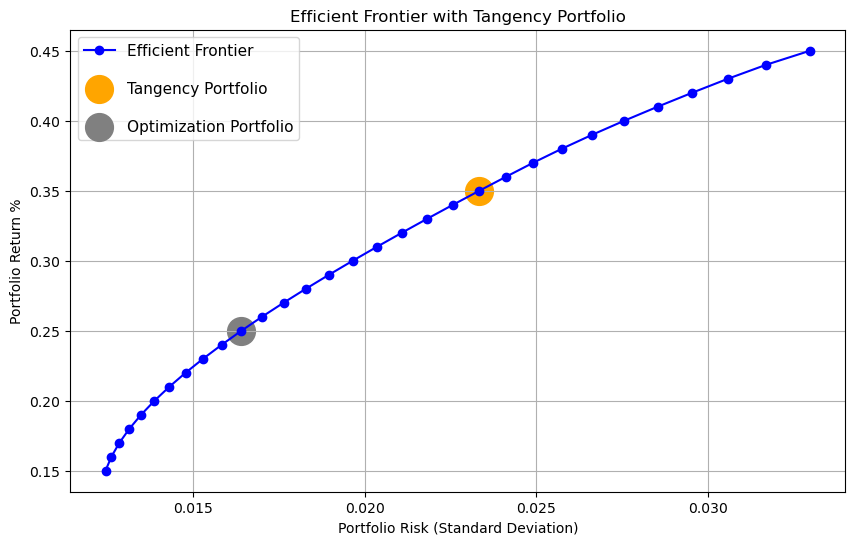

In [62]:
# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.plot(df["Portfolio_Risk"], df["Target_Return"], marker='o', linestyle='-', color='b', label="Efficient Frontier")

# Mark the Tangency Portfolio
plt.scatter(
    tangency_portfolio["Portfolio_Risk"], tangency_portfolio["Target_Return"],
    color='orange', marker='o', s=400, label="Tangency Portfolio"
)

# Mark the First Optimal Portfolio
plt.scatter(
    opt_portfolio["Portfolio_Risk"], opt_portfolio["Target_Return"],
    color='grey', marker='o', s=400, label="Optimization Portfolio"
)

# Labels and Title
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return %')
plt.title('Efficient Frontier with Tangency Portfolio')
plt.legend(fontsize=11, labelspacing=1.5)
plt.grid(True)
plt.show()